In [9]:
from pathlib import Path

import numpy as np
import pandas as pd


In [10]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator


In [ ]:
import os
import threadpoolctl
import warnings

import seaborn as sns

from rectools.metrics import MAP, calc_metrics, MeanInvUserFreq, Serendipity
from rectools.models import ImplicitALSWrapperModel
from rectools.dataset import Dataset
from implicit.als import AlternatingLeastSquares

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

# For implicit ALS
os.environ["OPENBLAS_NUM_THREADS"] = "1"
threadpoolctl.threadpool_limits(1, "blas")

In [11]:
catalog = pd.read_parquet(f'{Path.cwd().parent}/data/stokman_catalog_preprocessed.pq', engine='pyarrow')
catalog.head()

,add_date,shop_id,product_id,category_id,price,title,old_price
0,2024-09-30 03:07:09,350,1025536,8922,6990,6048 48557 44342 53515 17614,6990
1,2024-09-19 03:07:08,350,1025614,10600,330,42548 40244 23485 10853 6545 2343,330
2,2024-09-30 03:07:09,350,1025656,231,13240,14034 42002 48557 56089 46836 55620 50785,26490
3,2024-09-30 03:07:09,350,1025659,14546,7550,32640 50164 48557 25314 23255 42146,12590
4,2024-09-30 03:07:09,350,1025668,1949,1290,51789 48557 56089 20149,1290


In [12]:
actions = pd.read_parquet(f'{Path.cwd().parent}/data/train_actions_sorted.pq', engine='pyarrow')
actions.head()

,user_id,loc_user_id,action,date,products,pageId
0,6fd49b56-8cc6-11ed-86e0-002590c0647c,c6e357dc-121d-449d-a744-e9a0b56c2380,7,2024-09-07 00:00:04,[],2571824865
1,6fd49b56-8cc6-11ed-86e0-002590c0647c,c6e357dc-121d-449d-a744-e9a0b56c2380,7,2024-09-07 00:00:08,[],3834364438
2,f9c498ec-5d3b-11ef-86e0-002590c0647c,120c9064-1131-4dc3-8048-44184531b42e,7,2024-09-07 00:00:08,[],2448628415
3,59386b5c-e64f-11ec-8086-002590c82437,f0745572-893f-4e50-bc52-5af47badff5a,7,2024-09-07 00:00:11,[],3875013967
4,badbd396-6cab-11ef-86e0-002590c0647c,73423d85-d47c-4332-8155-5200615302b5,7,2024-09-07 00:00:11,[],3025531174


#### Разворачиваем данные по айдишникам продуктов

In [38]:
_actions = (
    actions
    .copy()
    .explode('products')
    .assign(products=lambda x: x.products.fillna(-1).astype(np.int64))
)
print(_actions.shape)

_catalog = (
    catalog
    .copy()
    .assign(product_id=lambda x: x.product_id.astype(np.int64))
)

(6859002, 6)


#### Разворачиваем данные по айдишникам продуктов

In [39]:
_actions['action_datetime'] = pd.to_datetime(_actions['date'])

_actions.action = _actions.action + 10
_actions.action = _actions.action.replace({14: 0, 13: 1, 18: 2, 19: 3, 10: 5, 17: 4, 11: 6, 12: 7, 16: 8, 15: 9})
print(_actions.shape)

(6859002, 7)


#### Новая шкала action в train_actions.pq в порядке возрастания важности
    0 - clearB (удаление всех товаров из корзины)
    1 - delB (удаление товара из корзины)
    2 - visitCategory (посещение страницы с группой товаров)
    3 - search (поиск товара)           
    4 - visit (посещение страницы с товаром)
    5 - view (просмотр товара)
    6 - like (лайк товара)
    7 - addB (добавление товара в корзину)
    8 - listB (посещение страницы корзины и вывод списка товаров в корзине)
    9 - order (оформление заказа)
    

#### переименовываем поля и обьеденияем датасеты каталога и дейсвтвий пользователя    

In [69]:
interactions = _actions.rename(columns={'products': 'item_id', 'action' : 'weight', 'action_datetime': 'datetime'})
interactions = interactions[interactions['item_id'] != '/*']

In [70]:
items = _catalog.rename(columns={'product_id': 'item_id'})

In [71]:
interactions_merge = interactions.merge(items, on='item_id', how='left')
interactions_merge.shape

(6859002, 13)

In [72]:
interactions_merge.sample()

,user_id,loc_user_id,weight,date,item_id,pageId,datetime,add_date,shop_id,category_id,price,title,old_price
2358390,187bdc62-2009-11ee-86e0-002590c0647c,4481bd75-b221-41ad-83c4-774b87c761aa,5,2024-09-14 21:18:47,5139433,4258660424,2024-09-14 21:18:47,2024-09-30 03:07:09,350,2111,6590.0,38730 46732 15745 32899,6590.0


In [73]:
sorted(interactions_merge.weight.unique()), len(interactions_merge.category_id.unique()), len(interactions_merge.pageId.unique())

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 1244)

In [74]:
interactions_merge['day'] = interactions_merge['datetime'].dt.day
interactions_merge['day_of_week'] = interactions_merge['datetime'].dt.dayofweek  # Monday=0, Sunday=6

interactions_merge['hour'] = interactions_merge['datetime'].dt.hour
interactions_merge['minute'] = interactions_merge['datetime'].dt.minute

In [75]:
interactions_merge.sample()

,user_id,loc_user_id,weight,date,item_id,pageId,datetime,add_date,shop_id,category_id,price,title,old_price,day,day_of_week,hour,minute
3954326,e38dc35e-a3c4-11ee-86e0-002590c0647c,2c09d985-5ab6-495b-b10a-02d6d7501605,2,2024-09-20 06:12:05,-1,171370293,2024-09-20 06:12:05,NaT,NaN,NaN,NaN,NaN,NaN,20,4,6,12


In [76]:
interactions_merge.shape

(6859002, 17)

In [78]:
interactions_merge['price_diff'] = interactions_merge['price'] - interactions_merge['old_price']

interactions_merge['category_id'] = interactions_merge['category_id'].fillna(0)
interactions_merge['price_diff'] = interactions_merge['price_diff'].fillna(0)

In [83]:
inters = interactions_merge.merge(
    interactions_merge.groupby('user_id')['loc_user_id'].count().reset_index(name='count'),
    on='user_id',
    how='left'
)
print(inters.shape)

(6859002, 19)


In [84]:
for action in sorted(interactions_merge.weight.unique()):
    inters = inters.merge(
        interactions_merge[interactions_merge.weight  == action].groupby('user_id')['weight'].count().reset_index(name=f'action_{action}_count'),
        on='user_id',
        how='left'
    )
    inters[f'action_{action}_count'] = inters[f'action_{action}_count'].fillna(0)
print(inters.shape)

(6859002, 29)


In [86]:
inters.sample(20)

,user_id,loc_user_id,weight,date,item_id,pageId,datetime,add_date,shop_id,category_id,...,action_0_count,action_1_count,action_2_count,action_3_count,action_4_count,action_5_count,action_6_count,action_7_count,action_8_count,action_9_count
5213890,2c5cf89c-6962-11ec-a6e9-002590c82437,4879a3bf-e8ec-4487-821f-f490ac91eea0,4,2024-09-24 06:01:16,-1,1823707769,2024-09-24 06:01:16,NaT,NaN,0,...,0.0,0.0,15.0,0.0,61.0,4.0,0.0,0.0,0.0,0.0
1394024,6ead6634-69d0-11ef-86e0-002590c0647c,4006bee7-2969-4512-8eca-715834297f93,8,2024-09-12 00:43:25,6391909,2590829625,2024-09-12 00:43:25,2024-09-25 16:08:23,350,375,...,0.0,6.0,46.0,0.0,187.0,60.0,0.0,9.0,95.0,3.0
211642,b2004a54-2304-11ef-9b7b-002590c82436,5e8419b2-1d52-4298-9cdc-44bc7bdde287,4,2024-09-07 18:33:43,-1,4110793588,2024-09-07 18:33:43,NaT,NaN,0,...,0.0,0.0,241.0,0.0,707.0,201.0,0.0,0.0,0.0,0.0
928009,b24bbbe0-8f10-11ec-a6e9-002590c82437,69ba0007-f050-4bfa-a71d-0d3c6ae3f0a4,4,2024-09-10 10:02:54,-1,2125387868,2024-09-10 10:02:54,NaT,NaN,0,...,0.0,0.0,8.0,0.0,58.0,15.0,0.0,3.0,4.0,0.0
6743735,ca996e04-4d7d-11e9-86e0-002590c0647c,98d1eafd-400a-4292-8a4d-87d0ff367349,5,2024-09-28 17:26:07,6404044,1507522782,2024-09-28 17:26:07,2024-09-30 03:07:09,350,1711,...,0.0,0.0,3.0,0.0,7.0,3.0,0.0,0.0,0.0,0.0
3645597,c7581430-9a5e-11ec-86e0-002590c0647c,544d675c-ddf3-4ce2-a2dc-ed3ca502ccdb,4,2024-09-19 08:27:22,-1,3387443320,2024-09-19 08:27:22,NaT,NaN,0,...,0.0,0.0,11.0,0.0,42.0,9.0,0.0,0.0,0.0,0.0
4912027,8a06f4c2-d1b1-11e7-86e0-002590c0647c,28bdb882-fdfd-4a30-95d3-1cf0c3feaf7c,4,2024-09-23 07:21:14,-1,1765316673,2024-09-23 07:21:14,NaT,NaN,0,...,0.0,0.0,19.0,0.0,79.0,17.0,0.0,2.0,2.0,0.0
4347907,1703507e-ff14-11ed-a1c4-002590c82437,1e68193a-b139-49b7-8384-5890acedcfd9,2,2024-09-21 11:14:54,-1,1464484931,2024-09-21 11:14:54,NaT,NaN,0,...,0.0,60.0,1188.0,1.0,3394.0,1219.0,0.0,95.0,203.0,33.0
6030633,9a893954-6164-11eb-a6e9-002590c82437,fabd217b-d6bc-420f-8514-7537cf4c68ff,4,2024-09-26 17:01:51,-1,2390655488,2024-09-26 17:01:51,NaT,NaN,0,...,0.0,33.0,375.0,0.0,1438.0,475.0,0.0,42.0,194.0,10.0
3461452,b58aa590-6d8f-11ef-9b7b-002590c82436,2f5d0fb9-bb02-4ca7-ad52-447ed3146d6f,4,2024-09-18 15:56:13,-1,3457957070,2024-09-18 15:56:13,NaT,NaN,0,...,0.0,0.0,3.0,0.0,5.0,2.0,0.0,0.0,0.0,0.0


In [88]:
inters = inters.drop(columns=['price', 'title', 'old_price', 'date', 'add_date', 'loc_user_id', 'shop_id'])

In [89]:
inters['delta_sec'] = inters.sort_values(by=['datetime']).groupby('user_id')['datetime'].diff()
inters['delta_sec'] = inters['delta_sec'].dt.total_seconds()
inters['delta_sec'] = inters['delta_sec'].fillna(0)

In [90]:
inters['delta_day'] = inters.sort_values(by=['datetime']).groupby('user_id')['day'].diff()
inters['delta_day'] = inters['delta_day'].fillna(0)

inters['delta_hour'] = inters.sort_values(by=['datetime']).groupby('user_id')['hour'].diff()
inters['delta_hour'] = inters['delta_hour'].fillna(0)

inters['delta_min'] = inters.sort_values(by=['datetime']).groupby('user_id')['minute'].diff()
inters['delta_min'] = inters['delta_min'].fillna(0)

In [91]:
inters = inters.drop(columns=['day', 'hour', 'minute'])

In [29]:
# inters = inters.drop(columns=['item_id'])

In [92]:
inters['is_useful'] = inters['weight'] > 4 

In [93]:
inters[inters.user_id == 'e4362420-f6ca-11ec-86e0-002590c0647c'].head(500)

,user_id,weight,item_id,pageId,datetime,shop_id,category_id,day_of_week,price_diff,count,...,action_5_count,action_6_count,action_7_count,action_8_count,action_9_count,delta_sec,delta_day,delta_hour,delta_min,is_useful
11,e4362420-f6ca-11ec-86e0-002590c0647c,4,-1,4263215769,2024-09-07 00:00:26,NaN,0,5,0.0,384,...,57.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,False
19,e4362420-f6ca-11ec-86e0-002590c0647c,4,-1,4263215769,2024-09-07 00:00:41,NaN,0,5,0.0,384,...,57.0,0.0,0.0,0.0,2.0,15.0,0.0,0.0,0.0,False
23,e4362420-f6ca-11ec-86e0-002590c0647c,4,-1,4263215769,2024-09-07 00:00:51,NaN,0,5,0.0,384,...,57.0,0.0,0.0,0.0,2.0,10.0,0.0,0.0,0.0,False
25,e4362420-f6ca-11ec-86e0-002590c0647c,4,-1,4263215769,2024-09-07 00:00:52,NaN,0,5,0.0,384,...,57.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,False
35,e4362420-f6ca-11ec-86e0-002590c0647c,9,5422963,4263215769,2024-09-07 00:01:12,350,2247,5,-5700.0,384,...,57.0,0.0,0.0,0.0,2.0,20.0,0.0,0.0,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6152873,e4362420-f6ca-11ec-86e0-002590c0647c,5,6770769,252042197,2024-09-27 06:14:04,350,50448,4,0.0,384,...,57.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,True
6152970,e4362420-f6ca-11ec-86e0-002590c0647c,4,-1,252042197,2024-09-27 06:14:20,NaN,0,4,0.0,384,...,57.0,0.0,0.0,0.0,2.0,16.0,0.0,0.0,0.0,False
6152981,e4362420-f6ca-11ec-86e0-002590c0647c,5,6990711,252042197,2024-09-27 06:14:21,350,50448,4,0.0,384,...,57.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,True
6152997,e4362420-f6ca-11ec-86e0-002590c0647c,4,-1,252042197,2024-09-27 06:14:24,NaN,0,4,0.0,384,...,57.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,False


In [264]:
def processing(purchasers):
    purchasers = purchasers.map(lambda x: [f'{y}' for y in x] if isinstance(x, list) else [f'{x}'])
    purchasers = list([item for sublist in purchasers for item in sublist])
    return list(set(purchasers))[:25]

In [ ]:
# baseline filter v4.2 - pd.Timedelta(5, unit='D') & (purchasers['weight'] > 7) & purchasers.iloc[purchasers.shape[0] - 3000:, :].item_id

In [970]:
last_5_days = inters['datetime'].max() - pd.Timedelta(5, unit='D')
purchasers = inters.sort_values(by=['datetime', 'weight'], ascending=True)
purchasers = purchasers[(purchasers['weight'] > 7) & (purchasers['datetime'] > last_5_days)]
purchasers = purchasers.groupby(['user_id'])['item_id'].apply(processing)
purchasers = purchasers.reset_index()
purchasers.shape

(3793, 2)

In [971]:
len(purchasers.user_id.unique())

3793

In [972]:
proved_ids = purchasers.iloc[purchasers.shape[0] - 3000:, :].item_id

In [973]:
purchasers = purchasers[purchasers.item_id.isin(proved_ids)]
print(purchasers.shape)
p = purchasers.iloc[purchasers.shape[0] - 3000:, :].reset_index(drop=True).rename(columns={'item_id': 'products'})
print(p.shape)
p.to_csv("predictions.csv", index=False)

(3052, 2)
(3000, 2)


In [974]:
print(pd.read_csv('predictions.csv').shape)
pd.read_csv('predictions.csv').sample(200)

(3000, 2)


,user_id,products
384,507ed48e-2012-11ef-9b7b-002590c82436,"['5114413', '6092723', '6112825']"
2812,f08c7a66-5a1a-11ef-86e0-002590c0647c,"['5897404', '1715166', '5230549', '3864580', '6729342', '5928955', '6214150', '807538', '1898206', '1898233', '2692978', '2702593', '5391193', '5109001', '5872915']"
1760,a9670390-5a42-11ef-86e0-002590c0647c,['5001964']
1855,b10a9ee0-7b31-11ee-86e0-002590c0647c,['4942675']
821,6cf47eb2-6113-11ed-ab15-002590c82437,"['1850045', '6143536', '5402779', '2682553', '4911277', '6143185']"
...,...,...
1195,84f8d5d2-7e1b-11ee-86e0-002590c0647c,"['4138767', '4914904', '4040538', '3777112', '3201988', '1407332', '4078893', '2741671']"
1281,8a069df2-5f20-11ef-86e0-002590c0647c,['1679595']
1113,8079ebd0-4e0a-11ef-86e0-002590c0647c,['5066056']
1407,9231a498-01c3-11ed-86e0-002590c0647c,['4999225']


In [324]:
max_date = inters['datetime'].max()
train_raw = inters[inters['datetime'] >= max_date - pd.Timedelta(days=14)].copy()
train_raw = train_raw[train_raw['datetime'] <= max_date - pd.Timedelta(days=3)]
test_raw = inters[inters['datetime'] > max_date - pd.Timedelta(days=3)].copy()

In [325]:
train = train_raw.drop(columns=['datetime', 'item_id', 'shop_id', 'pageId'])
test = test_raw.drop(columns=['datetime', 'item_id', 'shop_id', 'pageId'])

In [326]:
test.sample()

,user_id,weight,category_id,day_of_week,price_diff,count,action_0_count,action_1_count,action_2_count,action_3_count,...,action_5_count,action_6_count,action_7_count,action_8_count,action_9_count,delta_sec,delta_day,delta_hour,delta_min,is_useful
6312960,4b4a627e-0c94-11ec-8a53-0cc47a6d2fef,4,0,4,0.0,201,0.0,1.0,38.0,0.0,...,45.0,0.0,5.0,13.0,0.0,5.0,0.0,0.0,0.0,False


In [327]:
train.shape, test.shape

((3422180, 21), (1062417, 21))

In [328]:
train.weight.value_counts()

weight
4    2093607
2     517154
5     515541
8     190084
3      42703
7      26076
6      16084
1      14502
9       6238
0        191
Name: count, dtype: int64

In [329]:
train = train[train.weight.isin([0, 1, 3, 6, 7, 9])].drop_duplicates()
train.shape

(78203, 21)

In [330]:
train_portion = pd.concat(
    [train[train.weight.isin([0, 1, 3, 6, 7, 9])], train_raw.sample(78_000)],
    axis='rows'
)

In [331]:
train_portion.weight.unique()

array([7, 3, 6, 1, 9, 0, 2, 4, 5, 8])

In [332]:
train_h2o = h2o.H2OFrame(train_portion)
test_h2o = h2o.H2OFrame(test.sample(160_000))

In [333]:
y = "weight"
x = set(train_h2o.names) - set([y, 'user_id', 'shop_id', 'day', 'hour', 'pageId', 'datetime', 'item_id', 'is_useful'])
x

{'action_0_count',
 'action_1_count',
 'action_2_count',
 'action_3_count',
 'action_4_count',
 'action_5_count',
 'action_6_count',
 'action_7_count',
 'action_8_count',
 'action_9_count',
 'category_id',
 'count',
 'day_of_week',
 'delta_day',
 'delta_hour',
 'delta_min',
 'delta_sec',
 'price_diff'}

In [334]:
train_h2o[y] = train_h2o[y].asfactor()
test_h2o[y] = test_h2o[y].asfactor()

In [335]:
# train_h2o['is_useful'] = train_h2o['is_useful'].asfactor()
# test_h2o['is_useful'] = test_h2o['is_useful'].asfactor()

In [336]:
train_h2o['category_id'] = train_h2o['category_id'].asfactor()
test_h2o['category_id'] = test_h2o['category_id'].asfactor()

In [337]:
h2o.init(verbose=False)
print(f'{h2o.cluster().show_status()}')
h2o.no_progress()

H2O_cluster_uptime:,12 hours 42 mins
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_varsey_hsrv8g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,13.85 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


None


In [ ]:
gbm_model = H2OGradientBoostingEstimator(seed=1234)
gbm_model.train(x=list(x),
                y=y,
                training_frame = train_h2o,
                validation_frame = test_h2o,
                )

In [339]:
gbm_model.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,category_id,115934.929688,1.000000,0.446864
1,action_6_count,30175.240234,0.260277,0.116309
2,action_3_count,27399.675781,0.236337,0.105610
3,action_7_count,18472.289062,0.159333,0.071200
4,action_1_count,14832.882812,0.127941,0.057172
5,delta_min,12405.874023,0.107007,0.047818
6,action_4_count,11709.735352,0.101003,0.045134
7,action_8_count,10262.751953,0.088522,0.039557
8,count,4609.777832,0.039762,0.017768
9,delta_sec,4002.286133,0.034522,0.015427


In [ ]:
gbm_model.model_performance(test_h2o)

In [822]:
cats = inters.category_id.value_counts()
cats = cats.reset_index()
cats.category_id = cats.category_id.astype(int)
print(cats.columns)
selected_cat = cats[(cats['count'] > 1_00) & (cats['count'] != 0)].category_id.to_list()
len(selected_cat)

Index(['category_id', 'count'], dtype='object')


757

<Axes: >

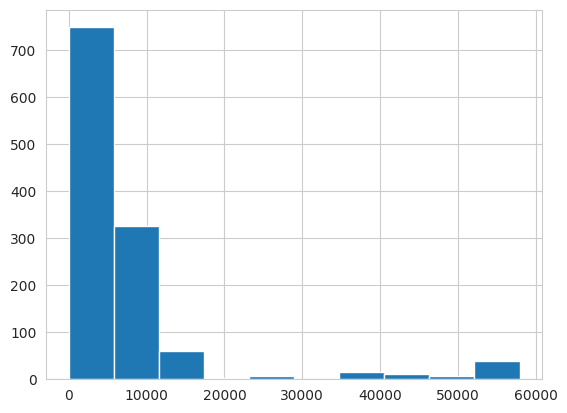

In [823]:
cats[(cats['count'] < 10000) & (cats['count'] != 0)]['category_id'].hist(bins=10)

In [1676]:
def calculate_recall(row):
    set_col1 = set(row['item_id_x'])
    set_col2 = set(row['item_id_y'])

    true_positives = len(set_col1.intersection(set_col2))
    false_negatives = len(set_col1) # len(set_col2 - set_col1)

    if true_positives + false_negatives == 0:  # Avoid division by zero
        return 0.0
    return true_positives / (true_positives + false_negatives)

In [1677]:
last_3_days = inters['datetime'].max() - pd.Timedelta(3, unit='D')
test_purchasers = inters.sort_values(by=['datetime', 'weight'], ascending=True)
test_purchasers = test_purchasers[(test_purchasers['weight'] == 9) & (test_purchasers['datetime'] > last_3_days)]
test_purchasers = test_purchasers.groupby(['user_id'])['item_id'].apply(processing)
test_purchasers = test_purchasers.reset_index()
test_purchasers.shape

(496, 2)

In [1891]:
last_3_days = inters['datetime'].max() - pd.Timedelta(0, unit='D')
last_8_days = inters['datetime'].max() - pd.Timedelta(5*25, unit='hours')
pred_purchasers = inters.sort_values(by=['datetime', 'weight'], ascending=True)
pred_purchasers = pred_purchasers[
    (pred_purchasers['weight'] > 7)
    & (pred_purchasers['datetime'] > last_8_days)
    & (pred_purchasers['datetime'] < last_3_days)
    & ((pred_purchasers.action_7_count > 50) | (pred_purchasers.action_8_count > 100) | (pred_purchasers.action_9_count > 0))
]
pred_purchasers = pred_purchasers.groupby(['user_id'])['item_id'].apply(processing)
pred_purchasers = pred_purchasers.reset_index()
pred_purchasers.shape

(1334, 2)

In [1892]:
pred_purchasers[pred_purchasers.user_id.isin(test_purchasers.user_id.unique())].shape

(496, 2)

In [1893]:
check_merge = test_purchasers.merge(pred_purchasers[-3000:], on='user_id', how='left')
check_merge.item_id_y.loc[check_merge.item_id_y.isnull()] = check_merge.item_id_y.loc[check_merge.item_id_y.isnull()].apply(lambda x: [])
check_merge.shape

(496, 3)

In [1894]:
check_merge.sample(1)

,user_id,item_id_x,item_id_y
46,128d43f8-c583-11ed-86e0-002590c0647c,"[5315221, 5482294, 4959439]","[5157772, 5482294, 4959556, 2785537, 1771257, 5033086, 5315221, 4959439, 5025892, 5315320]"


In [1895]:
check_merge['recall'] = check_merge.apply(calculate_recall, axis=1)
check_merge['recall'].mean()

0.49797213353943054

In [1896]:
print(pred_purchasers.shape)
p = pred_purchasers.iloc[pred_purchasers.shape[0] - 3000:, :].reset_index(drop=True).rename(columns={'item_id': 'products'})
print(p.shape)
p.to_csv("predictions.csv", index=False)

(1334, 2)
(1334, 2)


In [1803]:
inters['datetime'].min(), inters['datetime'].max()

(Timestamp('2024-09-07 00:00:04'), Timestamp('2024-09-28 23:59:59'))

In [1897]:
last_3_days = inters['datetime'].max() - pd.Timedelta(0, unit='D')
last_8_days = inters['datetime'].max() - pd.Timedelta(21, unit='D')
pred_data = inters[(inters['datetime'] > last_8_days) & (inters['datetime'] < last_3_days)]

In [1898]:
t = h2o.H2OFrame(pred_data[list(x)])

In [1899]:
preds = gbm_model.predict(t)

In [1900]:
res = pd.concat(
    [
        pred_data[list(x) + ['weight', 'user_id', 'item_id']].reset_index(drop=True),
        preds.as_data_frame().reset_index(drop=True)
    ],
    axis='columns',
)

In [1901]:
res['score'] = res[res.columns[-10:]].max(axis=1)
        

In [1902]:
# res[list(set(res.columns) - set(['user_id']))].sample(1000).corr()

In [1903]:
res[(res.predict > 5) & (res.category_id.isin(selected_cat)) ].groupby('user_id')['item_id'].agg(lambda x: list(map(str, x))[:25]).reset_index().shape

(14321, 2)

In [1929]:
res[
    (res.predict > 6)
    & (res.predict <= 7)
    & (res.category_id.isin(selected_cat))
    & (res.user_id.isin(test_purchasers.user_id.unique()))
    # & ((res.action_7_count > 1) | (res.action_8_count > 1) | (res.action_9_count > 1))
].groupby('user_id')['item_id'].agg(lambda x: list(set(map(str, x)))[:25]).reset_index().shape

(409, 2)

In [1930]:
ml_pred = res[
    (res.predict > 6)
    & (res.predict <= 7)
    & (res.category_id.isin(selected_cat))
    # & ((res.action_7_count > 1) | (res.action_8_count > 1) | (res.action_9_count > 1))
].groupby('user_id')['item_id'].agg(lambda x: list(set(map(str, x)))[:25]).reset_index()
ml_pred.shape

(11388, 2)

In [1931]:
# res[(res.predict == 7) & (res.user_id.isin(test_purchasers.user_id.unique()))]

In [1932]:
res[(res.predict > 7) & (res.category_id.isin(selected_cat)) & (res.user_id.isin(test_purchasers.user_id.unique())) & (res.action_7_count > 1) & (res.action_8_count > 1) & (res.action_9_count > 1)].shape

(4942, 33)

In [1933]:
pred_purchasers.shape

(1334, 2)

In [1938]:
data_to_check = pd.concat(
    [
        ml_pred.reset_index(drop=True),
        pred_purchasers.reset_index(drop=True),
        # res[(res.predict == 6) & (res.category_id.isin(selected_cat))].groupby('user_id')['item_id'].agg(lambda x: list(set(map(str, x)))[:25]).reset_index()
    ],
    axis='rows'
)
print(data_to_check.shape)
data_to_check = data_to_check.drop_duplicates(subset='user_id', keep='last') # .reset_index(drop=True)
print(data_to_check[data_to_check.user_id.isin(test_purchasers.user_id.unique())].shape)
data_to_check.shape

(12722, 2)
(496, 2)


(11622, 2)

In [1939]:
data_to_check[-3000:].shape

(3000, 2)

In [1940]:
# data_to_check = data_to_check[-3000:]
# print(data_to_check.shape)
# data_to_check.head()

In [1941]:
# check_merge_ml = test_purchasers.merge(data_to_check.sample(3000, random_state=42), on='user_id', how='left')
check_merge_ml = test_purchasers.merge(data_to_check[-3000:], on='user_id', how='left')
check_merge_ml.item_id_y.loc[check_merge_ml.item_id_y.isnull()] = check_merge_ml.item_id_y.loc[check_merge_ml.item_id_y.isnull()].apply(lambda x: [])
print(check_merge_ml.shape)
check_merge_ml['recall'] = check_merge_ml.apply(calculate_recall, axis=1)
check_merge_ml['recall'].mean()

(496, 3)


0.49797213353943054

In [1742]:
print(data_to_check.shape)
p = data_to_check.iloc[:3000, :].reset_index(drop=True).rename(columns={'item_id': 'products'})
print(p.shape)
p.to_csv("predictions.csv", index=False)

(9356, 2)
(3000, 2)


In [1366]:
last_3_days = inters['datetime'].max() - pd.Timedelta(days=3)
last_14_days = inters['datetime'].max() - pd.Timedelta(days=14)
train_raw = inters[(inters['datetime'] >= last_14_days) & (inters['datetime'] < last_3_days)].copy()
test_raw = inters[inters['datetime'] > last_3_days].copy()

In [1367]:
train_recs = train_raw[train_raw.item_id != -1].drop_duplicates(subset=['user_id', 'item_id']).copy()
test_recs = test_raw[test_raw.item_id != -1].drop_duplicates(subset=['user_id', 'item_id']).copy()

In [1368]:
# train_recs = train_raw[(train_raw.weight > 3)].drop_duplicates(subset=['user_id', 'item_id']).copy()
# test_recs = test_raw[(test_raw.weight > 3)].drop_duplicates(subset=['user_id', 'item_id']).copy()

In [1369]:
test_recs.weight.unique()

array([5, 8, 6, 7, 1])

In [1370]:
train_recs.shape, test_recs.shape

((397929, 25), (137852, 25))

In [1371]:
train_recs.drop_duplicates(subset=['user_id', 'item_id']).shape, test_recs.drop_duplicates(subset=['user_id', 'item_id']).shape

((397929, 25), (137852, 25))

In [1372]:
items = inters.copy()
items.sample()

,user_id,weight,item_id,pageId,datetime,shop_id,category_id,day_of_week,price_diff,count,...,action_5_count,action_6_count,action_7_count,action_8_count,action_9_count,delta_sec,delta_day,delta_hour,delta_min,is_useful
4437834,3547e2c4-a54f-11ea-8a53-0cc47a6d2fef,4,-1,864898271,2024-09-21 17:14:45,NaN,0,5,0.0,306,...,11.0,0.0,0.0,0.0,0.0,63.0,0.0,0.0,1.0,False


In [1373]:
items = items[items.item_id != -1].drop_duplicates(subset=['user_id', "category_id", 'price_diff'])
items.shape

(627108, 25)

In [1374]:
users = inters[['user_id', 'pageId', 'count']].copy()
users.shape

(6859002, 3)

In [1375]:
users = users.drop_duplicates(subset=['user_id', 'pageId'])
users.shape

(1421473, 3)

In [1376]:
cold_users = set(test_recs['user_id']) - set(train_recs['user_id'])
test_recs = test_recs.drop(test_recs[test_recs['user_id'].isin(cold_users)].index)
test_users = test_recs['user_id'].unique()
catalog=train_recs['user_id'].unique()

In [1377]:
train_recs.shape, test_recs.shape, len(cold_users)

((397929, 25), (67373, 25), 30566)

In [1703]:
dataset_no_features = Dataset.construct(
    interactions_df=train_recs[['user_id', 'item_id', 'weight', 'datetime']],
)


In [1386]:
metrics_name = {
    'MAP': MAP,
    'MIUF': MeanInvUserFreq,
    'Serendipity': Serendipity
}
metrics = {}
for metric_name, metric in metrics_name.items():
    for k in (25,):
        metrics[f'{metric_name}@{k}'] = metric(k=k)

In [1387]:
K_RECOS = 25
NUM_THREADS = 24
RANDOM_STATE = 32
ITERATIONS = 10

In [1388]:
def make_base_model(factors: int, regularization: float, alpha: float, fit_features_together: bool=False):
    return ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            alpha=alpha,
            random_state=RANDOM_STATE,
            use_gpu=False,
            num_threads = NUM_THREADS,
            iterations=ITERATIONS),
        fit_features_together = fit_features_together,
        )

In [1389]:
alphas = [10, 100]
regularizations = [0.1, 0.2]
factors = [256]

In [1390]:
results = []
dataset = dataset_no_features

recs = []
for alpha in alphas:
    for regularization in regularizations:
        for n_factors in factors:
            model_name = f"no_features_factors_{n_factors}_alpha_{alpha}_reg_{regularization}"
            print(model_name)
            model = make_base_model(factors=n_factors, regularization=regularization, alpha=alpha)
            model.fit(dataset)
            recos = model.recommend(
                users=test_users,
                dataset=dataset,
                k=K_RECOS,
                filter_viewed=False,
            )
            recs.append(recos)
            metric_values = calc_metrics(metrics, recos, test_raw, train_raw, catalog)
            metric_values["model"] = model_name
            results.append(metric_values)

no_features_factors_256_alpha_10_reg_0.1
no_features_factors_256_alpha_10_reg_0.2
no_features_factors_256_alpha_100_reg_0.1
no_features_factors_256_alpha_100_reg_0.2


In [1391]:
recos[recos.item_id == -1]

,user_id,item_id,score,rank


In [1392]:
pure_df = pd.DataFrame(results).set_index("model").sort_values(by=["MAP@25", "Serendipity@25"], ascending=False)
pure_df.head(5)

,MAP@25,MIUF@25,Serendipity@25
model,,,
no_features_factors_256_alpha_100_reg_0.1,0.009578,13.444757,0.000126
no_features_factors_256_alpha_100_reg_0.2,0.009551,13.494579,0.000126
no_features_factors_256_alpha_10_reg_0.1,0.008893,12.813678,0.000122
no_features_factors_256_alpha_10_reg_0.2,0.008888,12.824343,0.000122


In [1972]:
last_3_days = inters['datetime'].max() - pd.Timedelta(0, unit='D')
last_8_days = inters['datetime'].max() - pd.Timedelta(21, unit='D')
recos_data = inters[(inters['datetime'] > last_8_days) & (inters['datetime'] < last_3_days) & (inters['weight'] > 4)]

In [1973]:
recs_dataset = Dataset.construct(
    interactions_df=recos_data[['user_id', 'item_id', 'weight', 'datetime']],
)

model = make_base_model(factors=256, regularization=0.2, alpha=100)
model.fit(recs_dataset)

In [1974]:
recos = model.recommend(
    users=data_to_check[-3000:].user_id,
    dataset=recs_dataset,
    k=25,
    filter_viewed=False,
)

In [1975]:
recos[recos.item_id == -1]

,user_id,item_id,score,rank


In [1976]:
result = recos.groupby('user_id')['item_id'].agg(lambda x: list(map(str, x))).reset_index()

In [1977]:
result.head()

,user_id,item_id
0,0038911e-79a3-11ef-9b7b-002590c82436,"[1758351, 1628891, 928663, 1624568, 2745244, 905417, 2747827, 2691970, 1854727, 897321, 1854286, 4821607, 1640093, 5032951, 3623818, 6147385, 4795967, 6431560, 3914454, 1640060, 1665383, 2784478, 2747863, 1641779, 1286477]"
1,00a8fe40-024d-11ef-9b7b-002590c82436,"[6549439, 6101800, 6166786, 6411181, 5382928, 6456766, 3620404, 5177266, 2746507, 6166774, 6166789, 6101860, 6147727, 6101452, 6372010, 6277009, 6388237, 6185125, 6461368, 5724379, 6457720, 6552277, 6421486, 1779624, 5419735]"
2,00d23b34-6e90-11ef-9b7b-002590c82436,"[6415369, 6415366, 5214061, 5419288, 5214058, 6486397, 6627669, 5116486, 3876442, 4098729, 5006872, 593391, 4018857, 5018548, 4938682, 6588884, 698842, 869914, 1115023, 1025683, 4945939, 5052139, 7058487, 895379, 6217162]"
3,00d6623e-7086-11ef-86e0-002590c0647c,"[3709801, 5278573, 1551965, 3907086, 6645690, 6792456, 4018560, 1651307, 5932465, 4971997, 3721486, 1377644, 5244010, 1279529, 4899280, 5160019, 1605029, 2061748, 5940206, 3845038, 1605089, 4894237, 4082352, 1605041, 3725203]"
4,00efb9f8-0d3c-11ef-9b7b-002590c82436,"[5479060, 5478679, 5478931, 4005144, 5478691, 6531127, 6333205, 4821973, 1780488, 6337345, 6301267, 1779984, 6534091, 3771964, 4821967, 5698369, 6534001, 6533962, 3732679, 5479054, 6500092, 4821907, 4821883, 628514, 4915036]"


In [1978]:
r = result[result.user_id.isin(data_to_check[-3000:].user_id)]

In [1979]:
r.shape

(3000, 2)

In [1980]:
r_merge = data_to_check[-3000:].merge(r, on='user_id', how='left')

In [1981]:
r_merge.columns

Index(['user_id', 'item_id_x', 'item_id_y'], dtype='object')

In [1982]:
r_merge.item_id_y.loc[r_merge.item_id_y.isnull()] = r_merge.item_id_y.loc[r_merge.item_id_y.isnull()].apply(lambda x: [])

In [1983]:
r_merge['item_id'] = r_merge['item_id_x'] + r_merge['item_id_y']

In [1984]:
r_merge.sample(5)

,user_id,item_id_x,item_id_y,item_id
2132,58b2e29c-cbd2-11ee-86e0-002590c0647c,"[6672924, 6672927, 4959568, 6672945, 6806931, 6673251, 3732985, 6672717, 5052058, 5872960]","[4861441, 3882091, 1695984, 6100267, 5052058, 3717979, 6794997, 6794646, 5872960, 6405784, 6794643, 4959568, 6806931, 6672945, 6672924, 6672927, 4959598, 1865074, 6672741, 6672939, 6101539, 6673251, 6794658, 7049316, 7049298]","[6672924, 6672927, 4959568, 6672945, 6806931, 6673251, 3732985, 6672717, 5052058, 5872960, 4861441, 3882091, 1695984, 6100267, 5052058, 3717979, 6794997, 6794646, 5872960, 6405784, 6794643, 4959568, 6806931, 6672945, 6672924, 6672927, 4959598, 1865074, 6672741, 6672939, 6101539, 6673251, 6794658, 7049316, 7049298]"
1578,fdb9e76a-b5a7-11ec-a6e9-002590c82437,[5482288],"[5482288, 1780752, 6345292, 6340336, 5495353, 5743843, 5891002, 6282643, 6102820, 6130405, 3624922, 6544741, 6410149, 6185119, 5498866, 6372013, 5119348, 6345322, 3719650, 5891005, 1763307, 2752321, 5894056, 6548869, 5046442]","[5482288, 5482288, 1780752, 6345292, 6340336, 5495353, 5743843, 5891002, 6282643, 6102820, 6130405, 3624922, 6544741, 6410149, 6185119, 5498866, 6372013, 5119348, 6345322, 3719650, 5891005, 1763307, 2752321, 5894056, 6548869, 5046442]"
2763,ce262a6c-a913-11ed-86e0-002590c0647c,"[6671922, 6146878, 6091511, 6671928]","[1639925, 4999849, 5177455, 930432, 5177644, 5904715, 5456425, 5165155, 4999228, 387152, 6344224, 4873231, 6671928, 5114533, 6091511, 6671943, 5424547, 6671922, 4964062, 2696224, 6624351, 5885074, 6089585, 6671934, 3718237]","[6671922, 6146878, 6091511, 6671928, 1639925, 4999849, 5177455, 930432, 5177644, 5904715, 5456425, 5165155, 4999228, 387152, 6344224, 4873231, 6671928, 5114533, 6091511, 6671943, 5424547, 6671922, 4964062, 2696224, 6624351, 5885074, 6089585, 6671934, 3718237]"
2363,84f8d208-6524-11ef-86e0-002590c0647c,"[7037640, 823421]","[7097880, 6461533, 823421, 5342950, 5144350, 4894186, 6588041, 6407011, 7037640, 6225895, 6645846, 6461869, 6793491, 3913404, 3867781, 6598523, 6091040, 6526774, 5342953, 5336665, 5278189, 6100933, 6088934, 6462061, 5046247]","[7037640, 823421, 7097880, 6461533, 823421, 5342950, 5144350, 4894186, 6588041, 6407011, 7037640, 6225895, 6645846, 6461869, 6793491, 3913404, 3867781, 6598523, 6091040, 6526774, 5342953, 5336665, 5278189, 6100933, 6088934, 6462061, 5046247]"
1430,f9cd1f6a-5bd1-11ee-b1da-002590c82437,"[6275200, 6506959]","[4881631, 6275200, 5319352, 6344647, 6506959, 5319373, 5905753, 6343957, 6998484, 4881637, 6344644, 2678569, 5068111, 5886307, 5490082, 6836064, 6277546, 5324362, 5235334, 1854781, 6286366, 4861438, 4026726, 6593693, 6100876]","[6275200, 6506959, 4881631, 6275200, 5319352, 6344647, 6506959, 5319373, 5905753, 6343957, 6998484, 4881637, 6344644, 2678569, 5068111, 5886307, 5490082, 6836064, 6277546, 5324362, 5235334, 1854781, 6286366, 4861438, 4026726, 6593693, 6100876]"


In [1985]:
r_merge['item_id'] = r_merge['item_id'].apply(lambda x: list(set(x[:25]))) # make set

In [1986]:
r_merge = r_merge[['user_id', 'item_id']]

In [1987]:
r_merge.drop_duplicates(subset=['user_id']).shape

(3000, 2)

In [1992]:
r_merge.rename(columns={'item_id': 'products'}).reset_index().to_csv("r_final.csv", index=False)

In [1991]:
pd.read_csv('r_final.csv').shape

(3000, 3)

In [1990]:
check_merge_ml = test_purchasers.merge(r_merge[-3000:], on='user_id', how='left')
check_merge_ml.item_id_y.loc[check_merge_ml.item_id_y.isnull()] = check_merge_ml.item_id_y.loc[check_merge_ml.item_id_y.isnull()].apply(lambda x: [])
print(check_merge_ml.shape)
check_merge_ml['recall'] = check_merge_ml.apply(calculate_recall, axis=1)
check_merge_ml['recall'].mean()

(496, 3)


0.49797213353943054

In [176]:
h2o.cluster().shutdown()